# Exercise 1: Basic LeanIX AI Agent

## Goal

We want you to make yourself familiar with LeanIX and to learn how you can find information about Enterprise Applications of your company both in the LeanIX workspace as well as via an AI Agent based on MCP.

## Tasks

Your task is to answer the following Enterprise Architecture question: 

**Which applications have a perfect functional fit and fully appropriate technical fit?**

- first in LeanIX directly
- later with an AI Agent via MCP

We will go through these steps:

1. Find the information in LeanIX
1. Create LeanIX API token
1. Use the token to connect to the LeanIX MCP Server
1. Filter the MCP tools 
1. Connect to an LLM on AI Core
1. Create an AI Agent

Let's get started!

## Task 1.1: Find information in LeanIX

In order to answer the above question in LeanIX, we will navigate to the workspace and use a pre-built report to find the applications that match the defined criteria.

**🚧 Your task:** Please follow these steps

1. Log in to your [LeanIX demo workspace](https://demo-eu-9.leanix.net/SAPTechED/)
1. Navigate to Reports and select Application Portfolio report
1. Clear the filters for lifecycle and quality seal
1. Hover over the bubble in the upper right corner
1. Click on the bubble in the upper right corner
1. Click on "Show in Inventory"

### ✅ Solution
<details>
<summary>Click to expand solution</summary>

![Screenshot portfolio report](../../images/portfolio-report.png)

10 applications match these criteria

</details>

## Task 1.2: Create LeanIX API token

In order for us to access the same information via an external AI Agent, we need to create an API token. 

**🚧 Your task:** Please follow these steps:

1. In LeanIX, click on the user initials in the upper right corner
1. Select Administration
1. In the section "Discovery and Integrations" select "Technical Users"
1. Click on "New Technical User"
1. As a name type in "mcp`nnn`" with `nnn` being your assigned user number in the session (e.g., mcp001)
1. For permission role select "MEMBER"
1. Set the expiry date to the last day of the current month
1. Save the technical user and copy the API key 
1. Paste the API key to your `.env` file and assign it to the environment variable `LEANIX_API_TOKEN`

Your technical user configuration should look similar to this:

![Technical user](../../images/technical-user.png)


## Task 1.3: Connect to LeanIX MCP Server

Let's connect to the LeanIX MCP Server. We will use the API token from the previous step. 

#### Load API token

Let's first load the API token from the environment.

**🚧 Your task:** Execute the cell below and make sure it's loaded successfully.

In [15]:
import os
from dotenv import load_dotenv
load_dotenv()


LEANIX_API_TOKEN = os.getenv("LEANIX_API_TOKEN")

if LEANIX_API_TOKEN:
    print("LEANIX_API_TOKEN loaded successfully.")
else:
    print("Warning: LEANIX_API_TOKEN is not set or empty.")

LEANIX_API_TOKEN loaded successfully.


#### Connect to MCP Server

Now connect to the LeanIX MCP Server. The code below creates an MCP Client using the LangChain library to connect and get the tools. 

**🚧 Your task:** Execute the cell below.

In [16]:
import base64
import pandas as pd
from IPython.display import display, HTML
from langchain_mcp_adapters.client import MultiServerMCPClient

lx_api_token_base64 = base64.b64encode(
    f"apitoken:{LEANIX_API_TOKEN}".encode()
).decode()

client = MultiServerMCPClient(
    {
        "LeanIX MCP Remote": {
            "transport": "streamable_http",
            "url": "https://demo-eu-2.leanix.net/services/mcp-server/v1/mcp",
            "headers": {"Authorization": f"Basic {lx_api_token_base64}"},
        }
        # Add more servers as needed
    }
)

tools = await client.get_tools()

tool_data = [{
    'Name': tool.name,
    'Description': tool.description
} for tool in tools]

# Create DataFrame from tool data
df_tools = pd.DataFrame(tool_data)

# Truncate Description column to 200 characters
df_tools['Description'] = df_tools['Description'].apply(lambda x: x[:200] + ('...' if len(x) > 200 else ''))

# Show all text in columns and align left for readability
pd.set_option('display.max_colwidth', None)
styles = [
    {"selector": "th", "props": [("text-align", "left")]},
    {"selector": "td", "props": [("text-align", "left")]}
]

# Display the table
display(HTML(df_tools.style.set_table_styles(styles).to_html()))


,Name,Description
0,get_applications,"Search for application fact sheets with specific attributes. - To know which Fact Sheet types are available, use the `get_fact_sheet_types` tool first. - If the search fails or returns no results, us..."
1,get_architecture_templates,This function retrieves architecture decision templates from LeanIX for a workspace.
2,get_architecture_template_components,"This function retrieves the components for an architecture decision template via a given id from LeanIX for a workspace. Returns only id, title, and type of the components. Skips components missing ..."
3,get_reports,"Retrieves all stored reports a user can read. A report compiles and visualizes fact sheets with applied filters, views, properties and more. Result interpretation: The meaning of a report can be deri..."
4,get_fact_sheet_types,Return a list of all fact sheet types available in the LeanIX workspace. Call this tool first before using other tools that require specific fact sheet types.
5,get_overview,Get an overview about the LeanIX workspace. Retrieves fact sheet counts and shows the number of fact sheets per type.
6,get_fact_sheet_subscriptions,Get subscriptions for a fact sheet by id. The id will be returned by calling either the `search_fact_sheet_by_name` or `search_application_fact_sheets` tool.
7,get_fact_sheet_details,Get fact sheet details by fact sheet id.
8,get_initiatives,"Retrieve LeanIX initiative data via workspace relations, including lifecycle states, milestones, and connected architecture elements - To know which Fact Sheet types are available, use the `get_fact_..."
9,search_fact_sheet_by_name,"Search for fact sheets by name with optional type filtering. - Use this tool to search for fact sheets by their exact name. - If you need to search by other attributes, use the `text_to_fact_sheets` ..."


You should now see the tools available on the MCP Server.

## Task 1.4: Filter the MCP Tools

It is good practice to do some client-side filtering of tools as too many tools can overwhelm an LLM. Let's do some very basic filtering just based on keywords for the moment. In a real production system, we would rather implement a small Tools RAG.

**Your Task:**

Create a list `filtered_tools` which contains only the tools that have the word "application" in their description. Print the tools details to make yourself familiar with the selected tools.

In [ ]:
# Your code here

### ✅ Solution
<details>
<summary>Click to expand solution</summary>

```python
filtered_tools = [
    t for t in tools
    if "application" in (t.description or "").lower() 
]

print(f"Filtered tools ({len(filtered_tools)}):")
for tool in filtered_tools:
    print(f"Tool: {tool.name}")
    print(tool)
    print("------")
```

</details>

In [ ]:
filtered_tools = [
    t for t in tools
    if "application" in (t.description or "").lower() 
]

print(f"Filtered tools ({len(filtered_tools)}):")
for tool in filtered_tools:
    print(f"Tool: {tool.name}")
    print(tool)
    print("------")

## Task 1.5: Connect to an LLM via AI Core

Each MCP-based scenario always involves three players: 
- One or multiple MCP Servers 
- A Hosting app which connects to the MCP Servers and runs the AI Agents
- An LLM which makes the tooling decisions and generates the final answers to user requests

We will now add the LLM to the game in this task.

#### Initialize AI Core

We start with loading the AI Core credentials and connecting to an LLM.

**🚧 Your task:** Check that all environment variables are set in the .env file, then execute the cell below.

In [17]:
from gen_ai_hub.proxy.langchain import init_llm

# TODO: delpoy workshop model(s) and test again

AICORE_CLIENT_ID = os.getenv("AICORE_CLIENT_ID")
AICORE_CLIENT_SECRET = os.getenv("AICORE_CLIENT_SECRET")
AICORE_RESOURCE_GROUP = os.getenv("AICORE_RESOURCE_GROUP")
AICORE_BASE_URL = f"{os.getenv('AICORE_BASE_URL')}/v2/lm"
AICORE_AUTH_URL = f"{os.getenv('AICORE_AUTH_URL')}/oauth/token"

# Check if all variables are set (non-empty)
required_vars = [
    ('AICORE_CLIENT_ID', AICORE_CLIENT_ID),
    ('AICORE_CLIENT_SECRET', AICORE_CLIENT_SECRET),
    ('AICORE_RESOURCE_GROUP', AICORE_RESOURCE_GROUP),
    ('AICORE_BASE_URL', AICORE_BASE_URL),
    ('AICORE_AUTH_URL', AICORE_BASE_URL),
]
missing = [name for name, val in required_vars if not val]
if missing:
    print(f"Warning: The following AI Core environment variables are not set: {', '.join(missing)}")
else:
    print("All required AI Core environment variables are set.")


llm = init_llm("gpt-4.1", max_tokens=32767)

# Structured print of important LLM fields
fields = [
    ('model_name', getattr(llm, 'model_name', None)),
    ('max_tokens', getattr(llm, 'max_tokens', None)),
    ('temperature', getattr(llm, 'temperature', None)),
]
print("LLM Configuration")
for name, value in fields:
    if value is not None:
        print(f"  {name}: {value}")

All required AI Core environment variables are set.
LLM Configuration
  model_name: gpt-4.1
  max_tokens: 32767
  temperature: 0.0


#### Test the LLM

We now need to test if the LLM works as expected.

**🚧 Your task:** Invoke the `llm` instance with a test prompt and extract token usage from the response metadata.

In [ ]:
from IPython.display import Markdown, display
import pprint

# TODO: 🚧 Invoke the LLM with a test prompt
test_prompt = ""
response = llm.invoke(test_prompt)

# Print the output as Markdown
display(Markdown(f"**LLM Response:**\n\n{response.content}"))

# Debug print the full response object to understand its structure
pprint.pprint("Use this structure to find the right total tokens field")
pprint.pprint(f"debug string: {response}")

# TODO: Bonus 🚧 Extract the number of tokens used from the response metadata
# total_tokens = 
# display(Markdown(f"`Total tokens used: {total_tokens}`"))

### ✅ Solution

<details>
<summary>Click to expand solution</summary>

```python
from IPython.display import Markdown, display

response = llm.invoke("Hello world")

# Print the main response content as Markdown
display(Markdown(f"**LLM Response:**\n\n{response.content}"))

# Print the token usage in a highlighted way
total_tokens = response.response_metadata["token_usage"]["total_tokens"]
display(Markdown(f"`Total tokens used: {total_tokens}`"))
```

</details>

In [18]:
from IPython.display import Markdown, display

response = llm.invoke("Hello world")

# Print the main response content as Markdown
display(Markdown(f"**LLM Response:**\n\n{response.content}"))

# Print the token usage in a highlighted way
total_tokens = response.response_metadata["token_usage"]["total_tokens"]
display(Markdown(f"`Total tokens used: {total_tokens}`"))

**LLM Response:**

Hello! 🌍 How can I help you today?

`Total tokens used: 21`

## Task 1.6: Create AI Agent

Now we want to tackle the 3rd player of the MCP scenario and create an AI Agent that exposes MCP tools to an LLM to answer questions. We use a ReAct Agent from the LangGraph library for this purpose.


#### Understanding ReAct Agents

A **ReAct agent** (Reason + Act) is an AI agent that can both reason about problems and take actions using external tools. In LangGraph, a ReAct agent can:

- Think step-by-step about a user's question
- Decide when to use a tool (like searching in LeanIX)
- Combine information from multiple sources
- Respond in a way that's easy for employees to understand

The agent acts as a knowledgeable guide that knows how to look up information and explain it clearly to internal users.

#### Initialize AI Agent

We define the a LangGraph ReAct Agent with the cell below. 

**🚧 Your task:** Run the cell below to create the Agent.

/var/folders/sz/66lxrm6s76sbh7d0z6hcptcc0000gn/T/ipykernel_31763/1972124182.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent =  create_react_agent(llm, filtered_tools)


Initialized Agent: <langgraph.graph.state.CompiledStateGraph object at 0x16bf831a0>


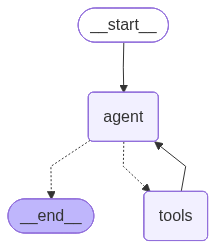

In [19]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Markdown, display, Image 

agent =  create_react_agent(llm, filtered_tools)
print(f"Initialized Agent: {agent}")

async def call_agent(agent, query):
    response = await agent.ainvoke(
        {
            "messages": [
                {"role": "user", "content": query}
            ]
        }
    )
    return response

def print_agent_response(response):
    msgs = response.get("messages", [])
    for msg in reversed(msgs):
        content = getattr(msg, "content", "")
        if content:
            display(Markdown(content))
            break
    else:
        print("No printable content in agent response.")


display(Image(agent.get_graph().draw_mermaid_png()))


You can see the structure of the Agent in the graph. It's a simple loop deciding on tools and calling tools until the Agent thinks it has reached its goal.

#### Call the Agent

**Task:** Now call the Agent to answer the question "Which applications have a perfect functional fit and fully appropriate technical fit?" and print the answer.

In [ ]:
### Your code here

### ✅ Solution
<details>
<summary>Click to expand solution</summary>

```python
response = await call_agent(
    agent, 
    "Which applications have a perfect functional fit and fully appropriate technical fit?"
)
print_agent_response(response)
```

</details>

In [ ]:
response = await call_agent(
    agent, 
    "Which applications have a perfect functional fit and fully appropriate technical fit?"
)
print_agent_response(response)

Congratulations! You have successfully mastered this exercise.